# Introduction

Check the performance of a set of experiments the DCC says is ready for release

In [1]:
import pandas
import sys
import os
from matplotlib import pyplot
from pathlib import Path

In [2]:
EC = str(Path("~/proj/encoded_client").expanduser())
if EC not in sys.path:
    sys.path.append(EC)

In [3]:
from encoded_client.encoded import ENCODED, get_object_type

In [4]:
server = ENCODED("www.encodeproject.org")
server.load_netrc()

In [5]:
search = "https://www.encodeproject.org/search/?type=Experiment&@id=%2Fexperiments%2FENCSR479MNN%2F&@id=%2Fexperiments%2FENCSR288RRZ%2F&@id=%2Fexperiments%2FENCSR899OKE%2F&@id=%2Fexperiments%2FENCSR464VSR%2F&@id=%2Fexperiments%2FENCSR774MGO%2F&@id=%2Fexperiments%2FENCSR129VBC%2F&@id=%2Fexperiments%2FENCSR420YFF%2F&@id=%2Fexperiments%2FENCSR942YMN%2F&@id=%2Fexperiments%2FENCSR648YUM%2F&@id=%2Fexperiments%2FENCSR903XMI%2F&@id=%2Fexperiments%2FENCSR244HHV%2F&@id=%2Fexperiments%2FENCSR168PXI%2F&@id=%2Fexperiments%2FENCSR308XAR%2F&@id=%2Fexperiments%2FENCSR484WZL%2F"


In [6]:
graph = server.get_json(search)

/experiments/ENCSR288RRZ/
/experiments/ENCSR899OKE/
/experiments/ENCSR479MNN/
/experiments/ENCSR648YUM/
/experiments/ENCSR942YMN/
/experiments/ENCSR420YFF/
/experiments/ENCSR484WZL/
/experiments/ENCSR308XAR/
/experiments/ENCSR464VSR/
/experiments/ENCSR244HHV/
/experiments/ENCSR903XMI/
/experiments/ENCSR168PXI/
/experiments/ENCSR129VBC/
/experiments/ENCSR774MGO/


In [8]:
experiment = server.get_experiment("/experiments/ENCSR288RRZ/")

In [20]:
def format_alias(alias):
    return ",".join([x.split(':')[1] for x in alias])

def filter_gene_type_metric(metric):
    to_remove = [
        "@id", 
        "@type", 
        "aliases", 
        "assay_term_name",
        "assay_term_id",
        "attachment", 
        "date_created", 
        "quality_metric_of", 
        "schema_version",
        "status",
        "step_run",
        "submitted_by",
        "lab", 
        "award", 
        "uuid"
    ]
    filtered_metric = metric.copy()
    for remove in to_remove:
        if remove in filtered_metric:
            del filtered_metric[remove]
        else:
            print("Warning {} not found".format(remove))
    return filtered_metric


def plot_gene_type_metric(gene_types):
    f = pyplot.figure(figsize=(8,8))
    ax = f.add_subplot(1,1,1)
    return gene_types.T.plot.bar(stacked=True, ax=ax)

    
def report_experiment(experiment):
    print(experiment['accession'], experiment['description'])
    
    star_quality = {}
    gene_types = {}
    for replicate in experiment.replicates:
        alias = format_alias(replicate["library"]["aliases"])


        for file in replicate["files"]:
            for i, metric in enumerate(file["quality_metrics"]):
                metric_for = ",".join(file._json["quality_metrics"][i]["quality_metric_of"])
                if get_object_type(metric) == "StarQualityMetric":
                    mapped = metric['Number of reads mapped to multiple loci'] + metric['Uniquely mapped reads number']
                    fraction_mapped = mapped / metric['Number of input reads']                    
                    star_quality[(alias, file["output_type"])] = {
                        'multi': metric['Number of reads mapped to multiple loci'],
                        'uniq': metric['Uniquely mapped reads number'],
                        'mapped': mapped,
                        'total': metric['Number of input reads'],
                        '%mapped': "{:.4}".format(fraction_mapped * 100),
                    }
                    #print(alias, metric)
                elif get_object_type(metric) == "MadQualityMetric":
                    spearman = metric["Spearman correlation"]
                    print(alias, metric_for, spearman)
                elif get_object_type(metric) == "GeneTypeQuantificationQualityMetric":
                    gene_types[alias] = filter_gene_type_metric(metric)

    print(pandas.DataFrame(star_quality).T)
    plot_gene_type_metric(pandas.DataFrame(gene_types))
    return

        
    gene_type = {}
    for library_alias in reports['GeneTypeQuantificationQualityMetric']:
        formatted_alias = format_alias(library_alias)
        gene_type_counts = reports['GeneTypeQuantificationQualityMetric'][library_alias]
        del gene_type_counts['@id']
        del gene_type_counts['quality_metric_of']
        gene_type[formatted_alias] = gene_type_counts
        
    gene_type = pandas.DataFrame(gene_type)
    f = pyplot.figure(figsize=(8,8))
    ax = f.add_subplot(1,1,1)
    gene_type.T.plot.bar(stacked=True, ax=ax)
    #return gene_type   

ENCSR288RRZ Stam Placenta 11005
                                  multi      uniq    mapped     total %mapped
22563 alignments                9436562  48803906  58240468  59717364   97.53
      transcriptome alignments  9436562  48803906  58240468  59717364   97.53
ENCSR899OKE Stam Placenta 11008
                                  multi      uniq    mapped     total %mapped
22566 transcriptome alignments  7912224  42396080  50308304  51571583   97.55
      alignments                7912224  42396080  50308304  51571583   97.55
ENCSR479MNN Stam Placenta 11014
                                  multi      uniq    mapped     total %mapped
22572 alignments                5320447  35558318  40878765  41981425   97.37
      transcriptome alignments  5320447  35558318  40878765  41981425   97.37
ENCSR648YUM Stam Placenta 11012
                                   multi      uniq    mapped     total %mapped
22570 alignments                13195409  64895216  78090625  80185552   97.39
      transc

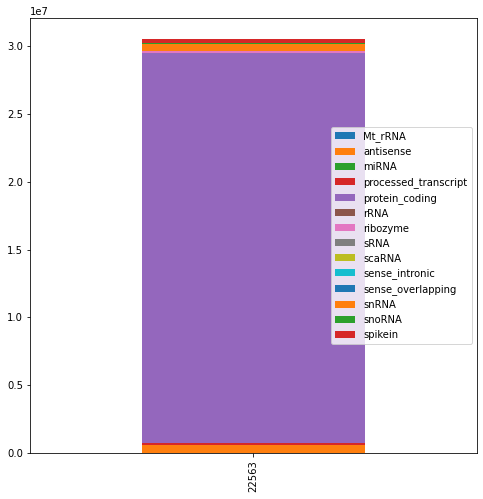

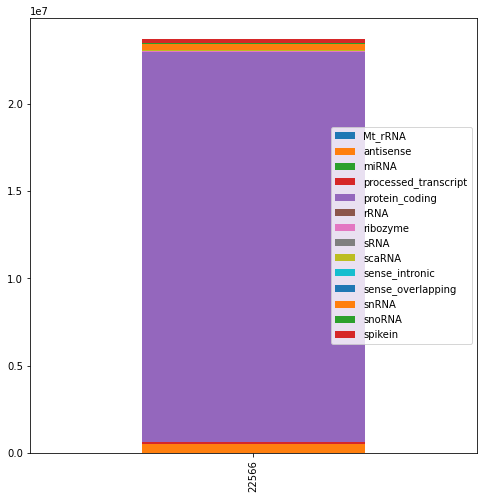

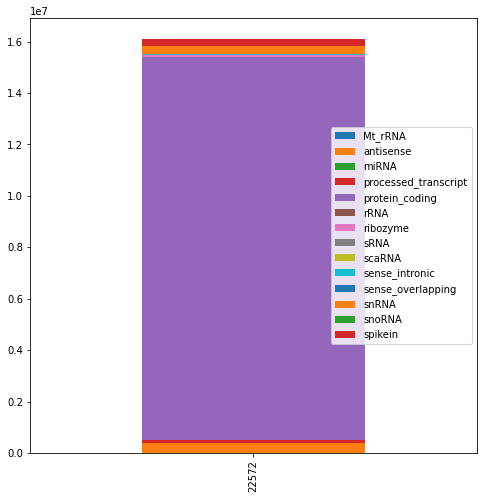

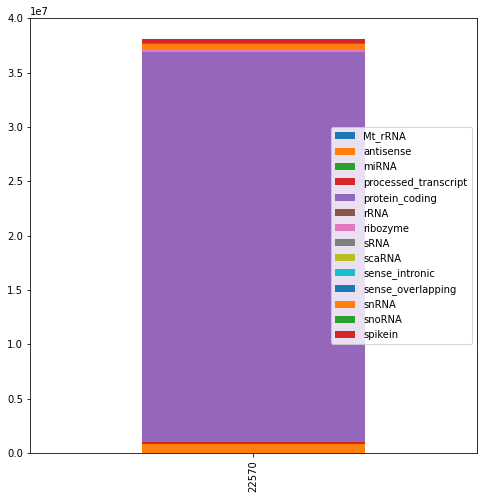

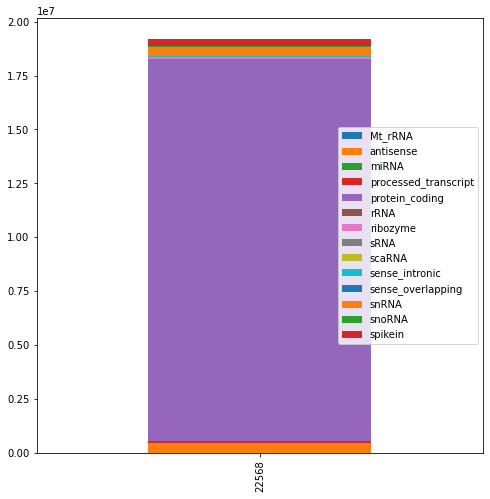

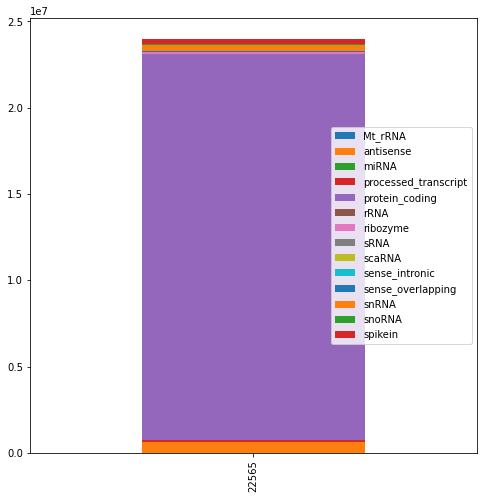

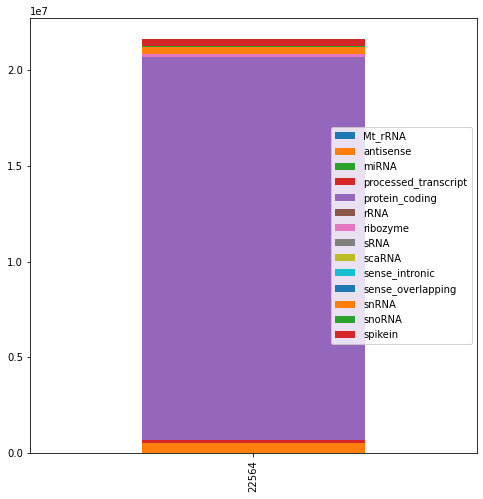

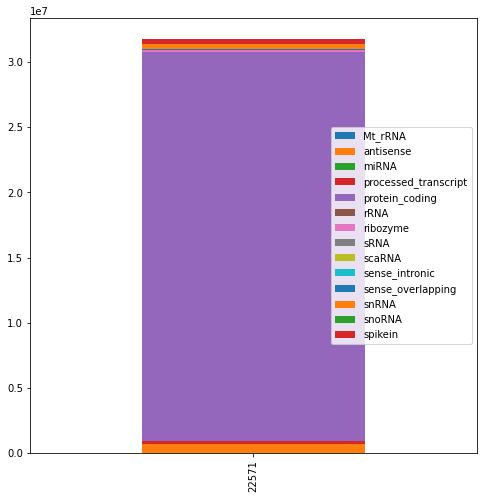

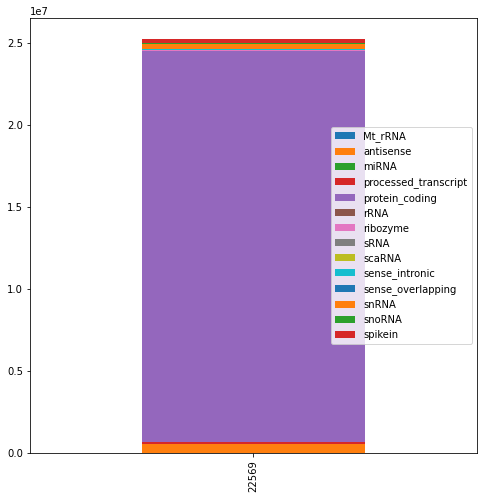

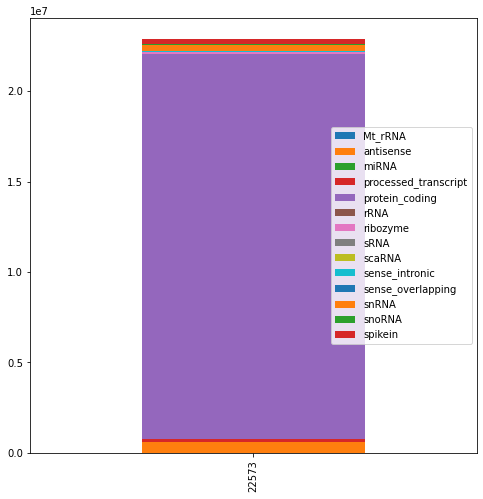

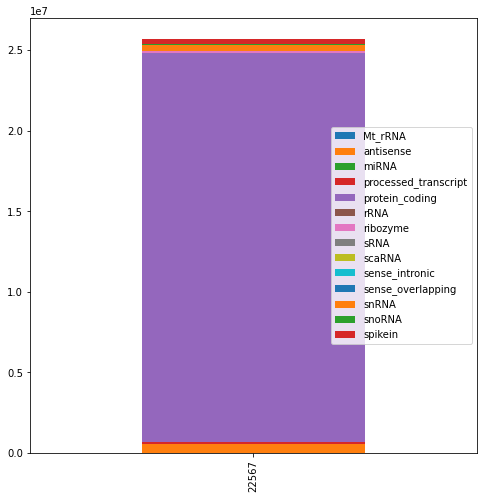

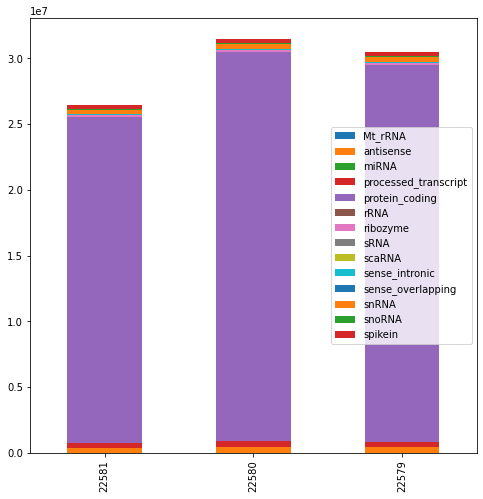

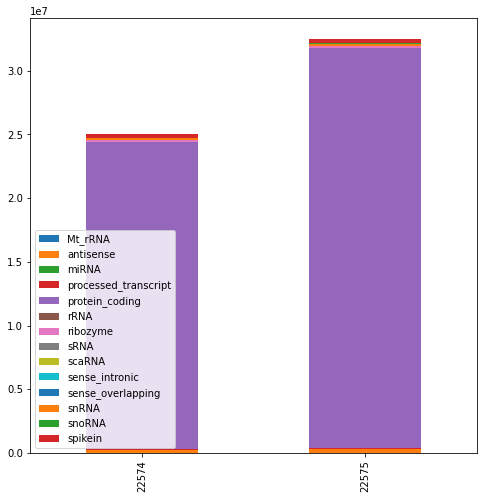

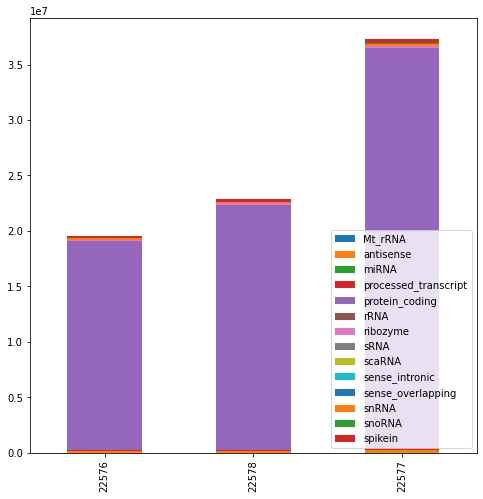

In [22]:
for row in graph["@graph"]:
    experiment = server.get_experiment(row["@id"])
    report_experiment(experiment)